In [14]:
WORD_NUM = 15 # MNRead has 15 words at most per line
penalty = 0.01

# Load in Data

In [15]:
import json
from pathlib import Path
import pandas as pd
import ast
from collections import Counter
from tqdm import tqdm

In [16]:
def count_matches_per_row(row):
    left_side = pd.Series(row['text'].lower().split(' '))
    right_side = pd.Series([i.lower() for i in row['rec_texts']])
    
    counter_left = Counter(left_side.dropna()) # dic
    counter_right = Counter(right_side.dropna())
    
    # 计算两侧相同元素的个数，确保每个元素只计算一次
    matches = sum((counter_left & counter_right).values())
    total = sum(counter_left.values())
    
    # char_level
    counter_left_char = Counter(''.join(left_side.dropna().tolist()))
    counter_right_char = Counter(''.join(right_side.dropna().tolist()))
    matches_char = sum((counter_left_char & counter_right_char).values())
    total_char = sum(counter_left_char.values())
    return [matches, total - matches, total_char-matches_char]


In [17]:
filter_df = pd.read_csv('../../data/human/SelectedFilter.csv')

In [ ]:
output_dir = Path("../../filtered/fonts")
gt_dir = Path("../../data/fonts")
files = list(output_dir.rglob('*.*'))
result_li = []
# Load the ground truth COCO JSON (annotations only or full dataset)
with open(gt_dir/"anno.json", "r") as f:
    ground_truth = json.load(f)
# Here we assume ground_truth has a key "annotations"
gt_annotations = ground_truth.get("annotations", [])
img_info = ground_truth.get("images", [])

for model_file in tqdm(files, total=len(files), desc="Rinse model outputs"):
    # Load the model output JSON (replace with your file or object)
    # model_file = output_dir/ "gpt4o.json"
    model_name = model_file.stem
    with open(model_file, "r") as f:
        model_output = json.load(f)

    # Create lookup dictionaries for ground truth annotations and image info by image_id.
    # If there are multiple ground truth annotations per image, you might need to store a list.
    gt_by_chart = {}
    for info, ann in zip(img_info, gt_annotations):
        id = ann["id"]
        full = {}
        full["image_id"] = ann["image_id"]
        full["file_name"] = info["file_name"]
        full["Filter_no"] = info["Filter_no"]
        full["text"] = ann["caption"]
        gt_by_chart.setdefault(id, full)
        
    
    # Now iterate through the model outputs and match with ground truth and image info
    full_out = {}
    for output_item in model_output:
        image_id = output_item["image_id"]
        
        # Optionally, if your model output's "rec_texts" is a string representation of a list,
        # convert it to an actual list.
        rec_texts_str = output_item.get("rec_texts", "")
        try:
            rec_texts = ast.literal_eval(rec_texts_str)
        except Exception:
            rec_texts = rec_texts_str
        output_item["rec_texts"] = rec_texts

        # Retrieve corresponding ground truth annotations (if any)
        gt_matches = gt_by_chart.get(image_id, {})
        tmp_file_name = Path(gt_matches.get("file_name", " _ _ _ _ _ ")).stem
        if 'CK_Bold' in tmp_file_name:
            tmp_file_name = tmp_file_name.replace('CK_Bold', 'CK-Bold')
        phase, font, viscond, chart_no, printsize = tmp_file_name.split("_")
        full_out[image_id] = gt_matches
        full_out[image_id]["rec_texts"] = rec_texts
        full_out[image_id]["phase"] = phase
        full_out[image_id]["font"] = font
        full_out[image_id]["chart_no"] = chart_no
        full_out[image_id]["viscond"] = viscond
        full_out[image_id]["printsize"] = printsize
        full_out[image_id]["lower_bound"] = -0.3 if viscond == 'Normal' else 0.4
        
        
    df = pd.DataFrame(full_out.values())

    df[['match','missing','missing_char']] = df.apply(lambda row: count_matches_per_row(row), axis=1).apply(pd.Series)
    df['missing_clipped'] = df['missing'].clip(upper=10)


    group_sum = df.groupby(['phase', 'font', 'viscond', 'chart_no']).apply(lambda x: x['lower_bound'].mean() + x['missing_clipped'].sum()*penalty).reset_index()
    group_sum.columns = ['phase', 'font', 'viscond','chart_no', model_name]
    # group_sum = group_sum.groupby(['phase', 'font', 'viscond']).apply(lambda x: x['acuity'].mean()).reset_index()
    # group_sum.columns = ['phase', 'font', 'viscond',model_name]
    result_li.append(group_sum)


Rinse model outputs:   0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_2968550/1471632480.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_sum = df.groupby(['phase', 'font', 'viscond', 'chart_no']).apply(lambda x: x['lower_bound'].mean() + x['missing_clipped'].sum()*penalty).reset_index()
Rinse model outputs:   9%|▉         | 1/11 [00:00<00:02,  4.43it/s]/tmp/ipykernel_2968550/1471632480.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping co

In [19]:
from functools import reduce
summary_dir = Path("../../data/summary")
reduce(lambda left, right: pd.merge(left, right, on=['phase', 'font', 'viscond','chart_no']), result_li).to_csv(summary_dir/'fonts_0515.csv', index=False)

In [21]:
# Custom sheet names
sheet_names = [file.stem for file in files]

# Export to Excel
with pd.ExcelWriter(summary_dir/'fonts_detail_0515.xlsx',engine='openpyxl') as writer:
    for df, name in zip(result_li, sheet_names):
        df.to_excel(writer, sheet_name=name, index=False)

In [53]:
import pandas as pd
df1 = reduce(lambda left, right: pd.merge(left, right, on=['a', 'b', 'VA', 'CS', 'Cond']), result_li)
df2 = pd.read_csv(summary_dir/'MNREADSummary_0513.csv')
df_human = pd.read_csv('../../data/human/human_mnread_acuity.csv')
df_human = df_human.rename(columns={'acuity': 'human'})

In [54]:
final_df = pd.merge(pd.merge(df1, df_human, on=['a', 'b'],how='left'), df2, on=['a', 'b', 'VA','CS', 'Cond'], how='left')
models = ['human','gpt4o', 'gpt4o_mini', 'gemini_15_flash',
       'gemini_15_pro', 'gemini_2_flash', 'claude3_7_sonnet', 'claude3_5_haiku','cogvlm', 'Qwen2.5-VL-3B-Instruct',
       'Qwen2.5-VL-7B-Instruct', 'Qwen2.5-VL-32B-Instruct', 'google' ,'spts', 'maerec']#'qwen', 'maerec','spts', 'ppocr', 'azure', 'google']
final_df['Expected'] = final_df['VA']
final_df = final_df[['a', 'b', 'VA', 'CS', 'Cond', 'Expected'] + models]
final_df.to_csv(summary_dir/'mnread_combined_0513.csv', index=False)

# Figure

In [55]:
import pandas as pd
final_df_fig = pd.read_csv('../../data/summary/mnread_combined_0513.csv')#final_df.copy()
models = ['human','SeeingAI', 'gpt4o', 'gpt4o_mini', 'gemini_15_flash',
       'gemini_15_pro', 'gemini_2_flash', 'claude3_7_sonnet', 'claude3_5_haiku',
       'cogvlm','Qwen2.5-VL-3B-Instruct', 'Qwen2.5-VL-7B-Instruct', 'Qwen2.5-VL-32B-Instruct',
        'maerec','spts', 'google'] #'ppocr', 'azure',

final_df_fig[['Expected'] + models] =  final_df_fig[['Expected'] + models]  - final_df_fig.loc[15,['Expected'] + models]
final_df_fig.loc[final_df_fig['Cond']=='Original', 'Cond'] = 'Combined'

model_name_dict = {'human':'Human','SeeingAI':'SeeingAI', 'gpt4o':'GPT4O', 'gpt4o_mini':'GPT4O Mini', 
                   'gemini_15_flash':'Gemini-1.5 Flash','gemini_15_pro':'Gemini-1.5 Pro', 'gemini_2_flash':'Gemini-2 Flash', 
                   'claude3_7_sonnet':'Claude3.7 Sonnet', 'claude3_5_haiku':'Claude3.5 Haiku','cogvlm':'CogAgent',
                   'Qwen2.5-VL-3B-Instruct':'Qwen2.5-VL-3B', 'Qwen2.5-VL-7B-Instruct':'Qwen2.5-VL-7B', 'Qwen2.5-VL-32B-Instruct':'Qwen2.5-VL-32B',
                   'maerec':'DBNet++ & MaeRec','spts':'SPTS v2', 'ppocr':'PPOCR', 'azure':'Azure', 'google':'Google Vision'}
final_df_fig.rename(columns=model_name_dict, inplace=True)
models = [model_name_dict[i] for i in models if i in model_name_dict]

In [57]:
import pandas as pd
final_df_fig = pd.read_csv('../../data/summary/mnread_combined_0513.csv')#final_df.copy()
models = ['human','SeeingAI', 'gpt4o', 'gpt4o_mini', 'gemini_15_flash',
       'gemini_15_pro', 'gemini_2_flash', 'claude3_7_sonnet', 'claude3_5_haiku',
       'cogvlm','Qwen2.5-VL-3B-Instruct', 'Qwen2.5-VL-7B-Instruct', 'Qwen2.5-VL-32B-Instruct',
        'maerec','spts', 'google'] 
model_name_dict = {'human':'Human','SeeingAI':'SeeingAI', 'gpt4o':'GPT4O', 'gpt4o_mini':'GPT4O Mini', 
                   'gemini_15_flash':'Gemini-1.5 Flash','gemini_15_pro':'Gemini-1.5 Pro', 'gemini_2_flash':'Gemini-2 Flash', 
                   'claude3_7_sonnet':'Claude3.7 Sonnet', 'claude3_5_haiku':'Claude3.5 Haiku','cogvlm':'CogAgent',
                   'Qwen2.5-VL-3B-Instruct':'Qwen2.5-VL-3B', 'Qwen2.5-VL-7B-Instruct':'Qwen2.5-VL-7B', 'Qwen2.5-VL-32B-Instruct':'Qwen2.5-VL-32B',
                   'maerec':'DBNet++ & MaeRec','spts':'SPTS v2', 'ppocr':'PPOCR', 'azure':'Azure', 'google':'Google Vision'}
final_df_fig.rename(columns=model_name_dict, inplace=True)
models = [model_name_dict[i] for i in models if i in model_name_dict]
final_df_fig.loc[final_df_fig['Cond']=='Original', models] = final_df_fig.loc[final_df_fig['Cond']=='Original', models].apply(lambda x: 68*10**(x-.9)).round(3)
final_df_fig.loc[final_df_fig['Cond']=='Original', models]

,Human,SeeingAI,GPT4O,GPT4O Mini,Gemini-1.5 Flash,Gemini-1.5 Pro,Gemini-2 Flash,Claude3.7 Sonnet,Claude3.5 Haiku,CogAgent,Qwen2.5-VL-3B,Qwen2.5-VL-7B,Qwen2.5-VL-32B,DBNet++ & MaeRec,SPTS v2,Google Vision
15,4.964,4.291,4.365,4.651,4.441,4.34,4.416,4.759,4.87,10.654,4.493,4.416,4.493,9.226,8.512,5.559


In [58]:
etdrs =  pd.read_csv('../../data/summary/etdrs_combined_0331.csv')
models = ['human','SeeingAI', 'gpt4o', 'gpt4o_mini', 'gemini_15_flash',
       'gemini_15_pro', 'gemini_2_flash', 'claude3_7_sonnet', 'claude3_5_haiku',
       'cogvlm','Qwen2.5-VL-3B-Instruct', 'Qwen2.5-VL-7B-Instruct', 'Qwen2.5-VL-32B-Instruct',
        'maerec','spts', 'google'] 
model_name_dict = {'human':'Human','SeeingAI':'SeeingAI', 'gpt4o':'GPT4O', 'gpt4o_mini':'GPT4O Mini', 
                   'gemini_15_flash':'Gemini-1.5 Flash','gemini_15_pro':'Gemini-1.5 Pro', 'gemini_2_flash':'Gemini-2 Flash', 
                   'claude3_7_sonnet':'Claude3.7 Sonnet', 'claude3_5_haiku':'Claude3.5 Haiku','cogvlm':'CogAgent',
                   'Qwen2.5-VL-3B-Instruct':'Qwen2.5-VL-3B', 'Qwen2.5-VL-7B-Instruct':'Qwen2.5-VL-7B', 'Qwen2.5-VL-32B-Instruct':'Qwen2.5-VL-32B',
                   'maerec':'DBNet++ & MaeRec','spts':'SPTS v2', 'ppocr':'PPOCR', 'azure':'Azure', 'google':'Google Vision'}
etdrs.rename(columns=model_name_dict, inplace=True)
models = [model_name_dict[i] for i in models if i in model_name_dict]
etdrs.loc[etdrs['Cond']=='Original', models] = etdrs.loc[etdrs['Cond']=='Original', models].apply(lambda x: 248*10**(x -1.7)).round(3)
etdrs.loc[etdrs['Cond']=='Original', models]


,Human,SeeingAI,GPT4O,GPT4O Mini,Gemini-1.5 Flash,Gemini-1.5 Pro,Gemini-2 Flash,Claude3.7 Sonnet,Claude3.5 Haiku,CogAgent,Qwen2.5-VL-3B,Qwen2.5-VL-7B,Qwen2.5-VL-32B,DBNet++ & MaeRec,SPTS v2,Google Vision
15,4.285,4.116,4.376,4.244,5.262,5.181,4.654,5.949,5.103,36.965,5.103,4.583,4.799,4.513,82.121,5.552


In [59]:
total =  pd.read_csv('../../data/summary/totaltext_combined_0331.csv')
models = ['human','SeeingAI', 'gpt4o',
       'gpt4o_mini', 'gemini_15_flash', 'gemini_15_pro', 'gemini_2_flash',
       'claude3_7_sonnet', 'claude3_5_haiku', 'cogvlm',
       'Qwen2.5-VL-3B-Instruct', 'Qwen2.5-VL-7B-Instruct',
       'Qwen2.5-VL-32B-Instruct', 'dbpp_maerecB', 'spts', 'google']
model_name_dict = {'human':'Human','SeeingAI':'SeeingAI', 'gpt4o':'GPT4O', 'gpt4o_mini':'GPT4O Mini', 
                   'gemini_15_flash':'Gemini-1.5 Flash','gemini_15_pro':'Gemini-1.5 Pro', 'gemini_2_flash':'Gemini-2 Flash', 
                   'claude3_7_sonnet':'Claude3.7 Sonnet', 'claude3_5_haiku':'Claude3.5 Haiku','cogvlm':'CogAgent',
                   'Qwen2.5-VL-3B-Instruct':'Qwen2.5-VL-3B', 'Qwen2.5-VL-7B-Instruct':'Qwen2.5-VL-7B', 'Qwen2.5-VL-32B-Instruct':'Qwen2.5-VL-32B',
                   'db_maerecB':'DBNet & MAERec-B', 'db_maerecS':'DBNet & MAERec-S', 'dbpp_maerecB':'DBNet++ & MaeRec','dbpp_maerecS':'DBNet++ & MaeRec-S',
                   'spts':'SPTS v2', 'ppocr':'PPOCR', 'azure':'Azure', 'google':'Google Vision'}
total.rename(columns=model_name_dict, inplace=True)
models = [model_name_dict[i] for i in models if i in model_name_dict]
total.loc[total['Cond']=='Original', models]

,Human,SeeingAI,GPT4O,GPT4O Mini,Gemini-1.5 Flash,Gemini-1.5 Pro,Gemini-2 Flash,Claude3.7 Sonnet,Claude3.5 Haiku,CogAgent,Qwen2.5-VL-3B,Qwen2.5-VL-7B,Qwen2.5-VL-32B,DBNet++ & MaeRec,SPTS v2,Google Vision
15,0.930252,0.847458,0.938968,0.951156,0.889618,0.889614,0.88486,0.939621,0.900857,0.779661,0.915296,0.935455,0.953409,0.797619,0.87574,0.914286


In [16]:
total.groupby('Cond').mean()[models].T.round(3)[['Original','Horizontal', 'Vertical', 'Combined']]

Cond,Original,Horizontal,Vertical,Combined
Human,0.930,0.715,0.658,0.609
SeeingAI,0.847,0.720,0.531,0.472
GPT4O,0.939,0.775,0.743,0.642
GPT4O Mini,0.951,0.773,0.720,0.636
Gemini-1.5 Flash,0.890,0.747,0.534,0.568
Gemini-1.5 Pro,0.890,0.752,0.552,0.553
Gemini-2 Flash,0.885,0.785,0.666,0.646
Claude3.7 Sonnet,0.940,0.687,0.453,0.480
Claude3.5 Haiku,0.901,0.644,0.429,0.454
CogAgent,0.780,0.681,0.581,0.577


In [60]:
df = pd.concat([etdrs.loc[etdrs['Cond']=='Original', models],
                final_df_fig.loc[final_df_fig['Cond']=='Original', models],
                total.loc[total['Cond']=='Original', models]], axis=0).T
df.columns = ['ETDRS','MNREAD', 'TOTALTEXT']
df.sort_values(by=['MNREAD'], ascending=True, inplace=True)
## only keep 3 digits
df.round(3)

,ETDRS,MNREAD,TOTALTEXT
SeeingAI,4.116,4.291,0.847
Gemini-1.5 Pro,5.181,4.340,0.890
GPT4O,4.376,4.365,0.939
Gemini-2 Flash,4.654,4.416,0.885
Qwen2.5-VL-7B,4.583,4.416,0.935
Gemini-1.5 Flash,5.262,4.441,0.890
Qwen2.5-VL-3B,5.103,4.493,0.915
Qwen2.5-VL-32B,4.799,4.493,0.953
GPT4O Mini,4.244,4.651,0.951
Claude3.7 Sonnet,5.949,4.759,0.940


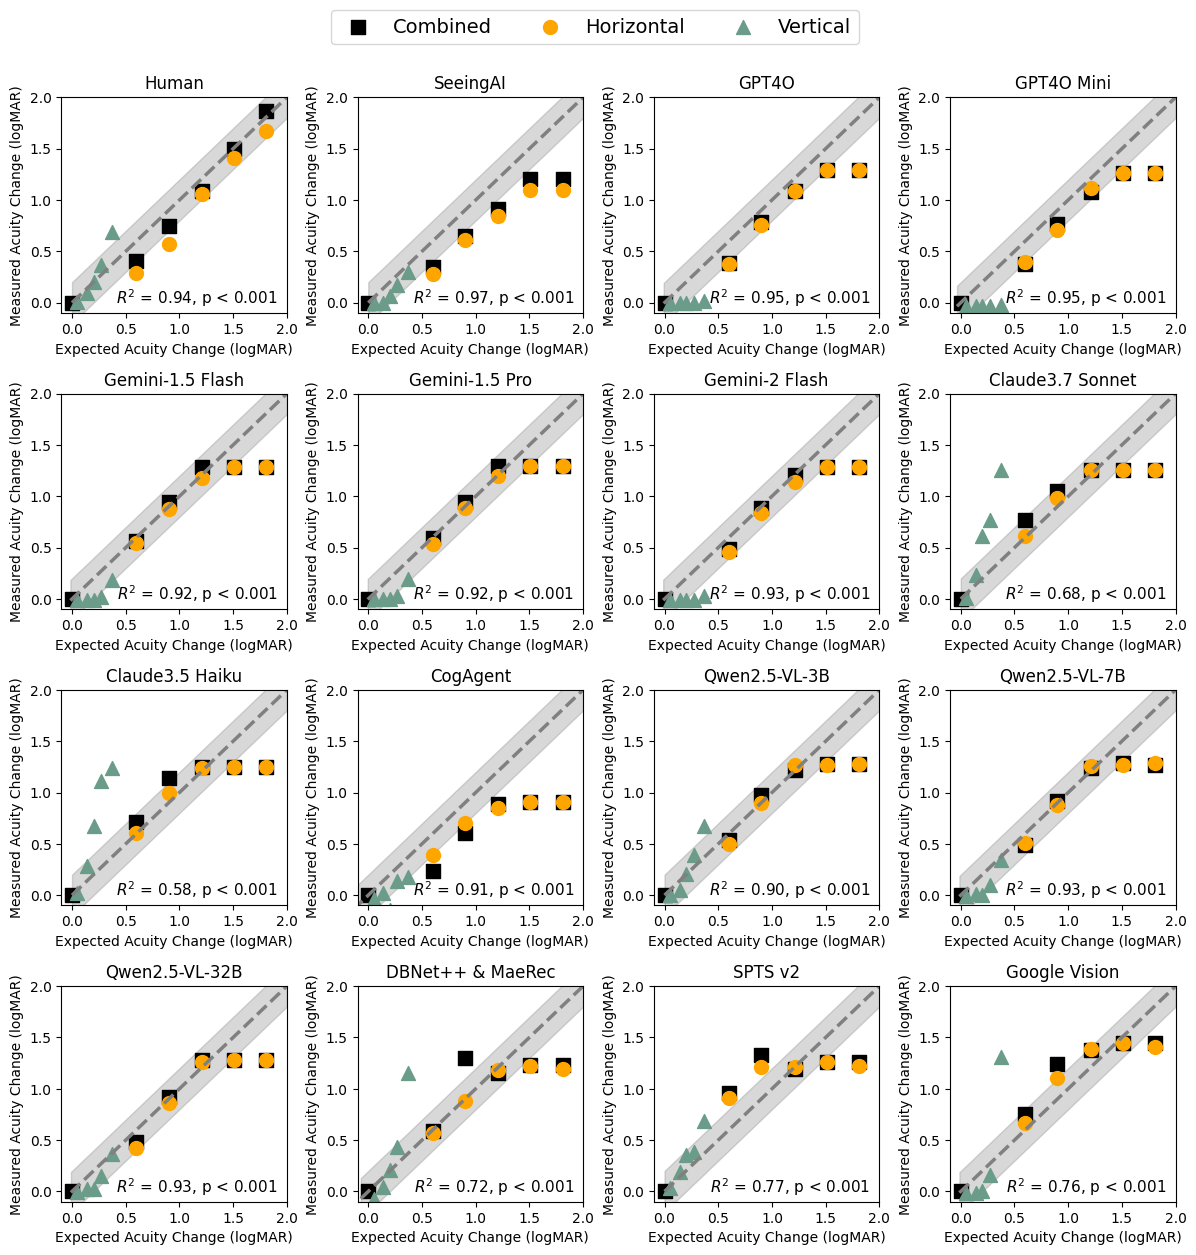

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np

# Define a function to choose marker based on condition
def get_marker(cond):
    if cond == 'Horizontal':
        return 'o'  # hollow square
    elif cond == 'Vertical':
        return '^'  # hollow triangle
    else:
        return 's'  # hollow circle

# Create a color palette for unique conditions
unique_conditions = final_df_fig['Cond'].unique()
# palette = sns.color_palette("viridis", len(unique_conditions))
# color_mapping = {cond: palette[i] for i, cond in enumerate(unique_conditions)}
colors = ['orange', 'black', '#6A9C89', 'black']
# Create the mapping
color_mapping = {cond: color for cond, color in zip(unique_conditions, colors)}

# Define a function to plot a scatter plot on a given axis for a specified model column
def plot_scatter(ax, model_col, df):
    # Add a dashed diagonal line that spans the range of the data
    x_vals = df['Expected']
    y_vals = df[model_col]
    overall_min = min(x_vals.min(), y_vals.min())
    overall_max = 2.0 #max(x_vals.max(), y_vals.max())
    ax.plot([overall_min, overall_max], [overall_min, overall_max],
            linestyle='--', color='grey', linewidth=2.5)
    x = np.linspace(overall_min, overall_max, 100)
    # Fill the area between y = x - 0.2 and y = x + 0.2
    ax.fill_between(x, x - 0.2, x + 0.2, color='grey', alpha=0.3)
    
    # Plot each group (by Cond) separately to assign markers and colors
    for cond, group in df.groupby('Cond'):
        marker = get_marker(cond)
        ax.scatter(
            group['Expected'],
            group[model_col],
            label=cond,
            marker=marker,
            facecolors=color_mapping[cond],  # makes marker hollow
            edgecolors=color_mapping[cond],
            s=100  # marker size
        )
    
    # calulate the correlation
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(x_vals.astype(float).to_numpy(), y_vals.astype(float).to_numpy())
    r_squared = r_value ** 2
    # Annotate R² and p-value in bottom-right
    ax.text(0.96, 0.02, f'$R^2$ = {r_squared:.2f}, '+ (f'p = {p_value:.3f}' if p_value > 0.001 else 'p < 0.001'),
            ha='right', va='bottom', transform=ax.transAxes,
            fontsize=11)

    
    # Set labels, title and legend
    ax.set_xlabel("Expected Acuity Change (logMAR)")
    ax.set_ylabel("Measured Acuity Change (logMAR)")
    ax.set_xlim(-0.1, 2.0)
    ax.set_ylim(-0.1, 2.0)
    ax.set_title(f"{model_col}")
    # ax.legend()

# List of models to plot (include 'human' and other models)
# models = ['human','SeeingAI' ,'gpt4o', 'gpt4o_mini', 'gemini_15_flash',
#        'gemini_15_pro', 'gemini_2_flash', 'claude3_7_sonnet', 'claude3_5_haiku',
#        'qwen', 'maerec','spts', 'ppocr', 'azure', 'google']

# Determine subplot grid layout; here we choose 2 columns
num_models = len(models)
ncols = 4
nrows = math.ceil(num_models / ncols)
nrows = math.ceil(num_models / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows))
# If there's only one subplot, axes is not an array; make it a list for consistency.
if num_models == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Plot each model in its corresponding subplot
for i, model in enumerate(models):
    plot_scatter(axes[i], model, final_df_fig)

# Remove any extra subplots if the grid has more axes than models
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
handles, labels = axes.flatten()[0].get_legend_handles_labels()

# Place a common legend outside the figure. Here, loc='upper center' puts it at the top,
# and bbox_to_anchor adjusts its position. Adjust ncol for number of columns in legend.
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=14)
plt.tight_layout()

plt.savefig('../../figure/mnread.pdf', dpi=300)

In [15]:
final_df_fig.loc[final_df_fig['Expected'] < 1.21, :]

,a,b,VA,CS,Cond,Expected,Human,GPT4O,GPT4O Mini,Gemini-1.5 Flash,...,Claude3.7 Sonnet,Claude3.5 Haiku,CogAgent,Qwen2.5-VL-3B,Qwen2.5-VL-7B,Qwen2.5-VL-32B,Google Vision,SPTS v2,DBNet++ & MaeRec,SeeingAI
6,0.125,1.000,0.66,1.96,Horizontal,0.9,0.718591,0.6525,0.6075,0.7825,...,0.915,0.93,0.631667,0.805,0.776667,0.768333,1.100833,1.2125,0.8775,0.613333
7,0.157,0.157,0.66,1.33,Combined,0.9,0.569464,0.6825,0.6675,0.8525,...,0.985,1.08,0.535,0.885,0.82,0.825,1.2375,1.3325,1.2975,0.65
8,0.250,1.000,0.36,2.05,Horizontal,0.6,0.324306,0.28,0.295,0.4525,...,0.5475,0.545,0.3175,0.405,0.4125,0.325,0.665,0.9125,0.57,0.28
9,0.288,0.288,0.36,1.59,Combined,0.6,0.225575,0.2825,0.2775,0.4725,...,0.695,0.65,0.165,0.445,0.39,0.385,0.7575,0.9625,0.5875,0.35
10,1.000,0.011,0.13,0.20,Vertical,0.37,0.641687,-0.0075,-0.0325,0.105833,...,1.181667,1.176667,0.131667,0.578333,0.253333,0.265,1.310833,0.689167,1.150833,0.303333
11,1.000,0.022,0.03,0.47,Vertical,0.27,0.680734,-0.0075,-0.0325,-0.004167,...,0.698333,1.053333,0.161667,0.298333,0.023333,0.071667,0.160833,0.3825,0.4375,0.17
12,1.000,0.045,-0.04,0.76,Vertical,0.2,0.43502,-0.0075,-0.029167,-0.0075,...,0.545,0.613333,-0.115,0.135,-0.006667,-0.001667,0.0075,0.359167,0.2075,0.066667
13,1.000,0.089,-0.10,1.06,Vertical,0.14,0.018591,-0.0075,-0.0325,-0.0075,...,0.165,0.22,0.035,0.031667,-0.003333,0.011667,-0.0125,0.1925,0.040833,0.0
14,1.000,0.355,-0.19,1.65,Vertical,0.05,0.085734,-0.0075,-0.0325,-0.0075,...,-0.011667,0.006667,-0.038333,-0.001667,-0.01,-0.008333,-0.0125,0.035833,-0.069167,0.0
15,1.000,1.000,-0.24,2.13,Combined,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


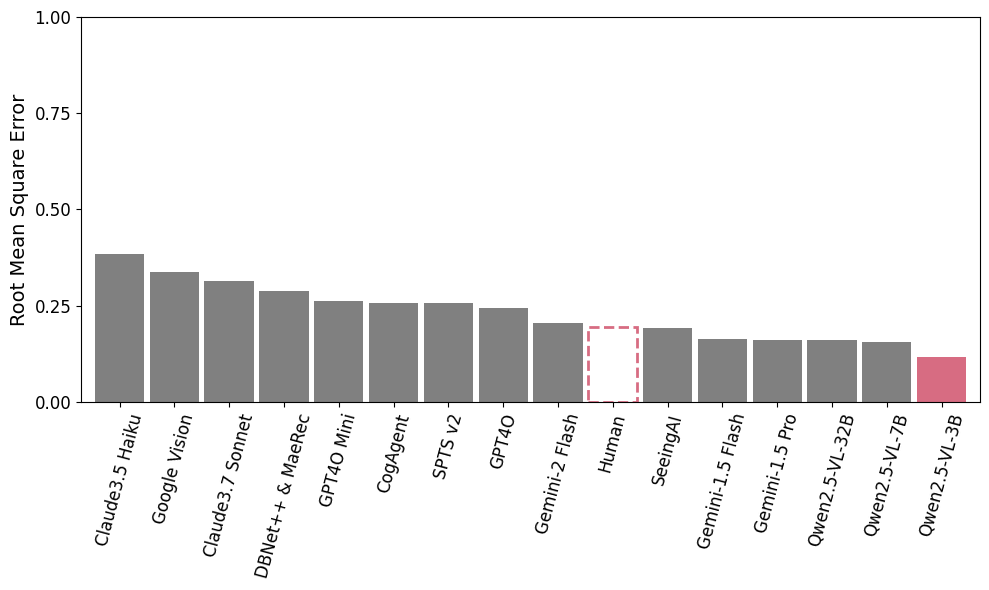

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np

def rmse(arr):
    return np.sqrt(np.mean(arr ** 2))
std_values = final_df_fig.loc[final_df_fig['Expected'] < 1.21, models].sub(final_df_fig['Expected'], axis=0).apply(rmse, axis=0)
# Identify the model with the smallest std
min_model = std_values.idxmin()

# Create a color list: red for the model with the smallest std; use a nice color (e.g. 'skyblue') for others.
colors = ['#D76C82' if model == min_model else 'gray' for model in std_values.index]

# Optional: sort the values for a prettier display (and sort colors accordingly)
std_values_sorted = std_values.sort_values(ascending=False)
colors_sorted = [colors[std_values.index.get_loc(model)] for model in std_values_sorted.index]
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
std_values_sorted.plot(kind='bar', color=colors_sorted, edgecolor='none', width=0.9, ax=ax)

for patch, tick in zip(ax.patches, ax.get_xticklabels()):
    if tick.get_text().lower() == 'human':  # adjust case if needed
        # Set no fill (hollow)
        patch.set_facecolor('none')
        # Set dashed edge
        patch.set_linestyle('--')
        patch.set_linewidth(2)
        # Optionally, set a specific edge color. For instance, if you want red:
        patch.set_edgecolor('#D76C82')
# Customize axis labels, title, and tick parameters
# plt.xlabel("Model", fontsize=14, fontweight='bold')
plt.ylabel("Root Mean Square Error", fontsize=14)
plt.yticks(np.arange(0,1.01,0.25),fontsize=12)
plt.xticks(rotation=75, fontsize=12)
plt.tight_layout()
plt.savefig('../../figure/mnread_rmse.pdf', dpi=300)


# Archive

In [ ]:
# Create lookup dictionaries for ground truth annotations and image info by image_id.
# If there are multiple ground truth annotations per image, you might need to store a list.
gt_by_chart = {}
for info, ann in zip(img_info, gt_annotations):
    id = ann["id"]
    full = {}
    full["image_id"] = ann["image_id"]
    full["file_name"] = info["file_name"]
    full["Filter_no"] = info["Filter_no"]
    full["text"] = ann["caption"]
    gt_by_chart.setdefault(id, full)


In [ ]:
import ast
# Now iterate through the model outputs and match with ground truth and image info
full_out = {}
for output_item in model_output:
    image_id = output_item["image_id"]
    
    # Optionally, if your model output's "rec_texts" is a string representation of a list,
    # convert it to an actual list.
    rec_texts_str = output_item.get("rec_texts", "")
    try:
        rec_texts = ast.literal_eval(rec_texts_str)
    except Exception:
        rec_texts = rec_texts_str
    output_item["rec_texts"] = rec_texts

    # Retrieve corresponding ground truth annotations (if any)
    gt_matches = gt_by_chart.get(image_id, {})
    chart_no, reso, row_no = Path(gt_matches.get("file_name", "___")).stem.split("_")
    full_out[image_id] = gt_matches
    full_out[image_id]["rec_texts"] = rec_texts
    full_out[image_id]["chart_no"] = chart_no
    full_out[image_id]["reso"] = reso
    full_out[image_id]["row_no"] = row_no
    
    

In [ ]:
from collections import Counter
import pandas as pd

def count_matches_per_row(row):
    left_side = pd.Series(row['text'].lower().split(' '))
    right_side = pd.Series([i.lower() for i in row['rec_texts']])
    
    counter_left = Counter(left_side.dropna()) # dic
    counter_right = Counter(right_side.dropna())
    
    # 计算两侧相同元素的个数，确保每个元素只计算一次
    matches = sum((counter_left & counter_right).values())
    total = sum(counter_left.values())
    
    # char_level
    counter_left_char = Counter(''.join(left_side.dropna().tolist()))
    counter_right_char = Counter(''.join(right_side.dropna().tolist()))
    matches_char = sum((counter_left_char & counter_right_char).values())
    total_char = sum(counter_left_char.values())
    return [matches, total - matches, total_char-matches_char]


In [ ]:

df = pd.DataFrame(full_out.values())
df = pd.merge(df, filter_df, on='Filter_no', how='inner')
# df['text'].str.split(" ", expand=True)
# # Split the 'text' column into separate columns using space as the delimiter
# split_text = df['text'].str.split(" ", expand=True)

# # Rename the split columns to L1, L2, ..., Ln
# split_text.columns = [f"L{i+1}" for i in range(split_text.shape[1])]

# # Concatenate the new columns back to the original DataFrame
# df = pd.concat([df, split_text], axis=1)
df[['match','missing','missing_char']] = df.apply(lambda row: count_matches_per_row(row), axis=1).apply(pd.Series)
df['missing_clipped'] = df['missing'].clip(upper=10)

group_sum = df.groupby(['chart_no','a', 'b', 'VA', 'CS', 'Cond']).apply(lambda x: -0.2 + x['missing_clipped'].sum()*penalty).reset_index()
group_sum.columns = ['chart_no', 'a', 'b', 'VA', 'CS', 'Cond','acuity']
group_sum = group_sum.groupby(['a', 'b', 'VA', 'CS', 'Cond']).apply(lambda x: x['acuity'].mean()).reset_index()
group_sum.columns = ['a', 'b', 'VA', 'CS', 'Cond',model_name]
group_sum
# df_merged = pd.merge(df, group_sum, on='chart_no', how='left')
# df_merged = df_merged[['image_id', 'file_name', 'Filter_no', 'text', 'rec_texts', 'chart_no',
#                        'row_no', 'a', 'b', 'VA', 'CS', 'Cond', 'acuity']]
# df_merged

/tmp/ipykernel_2338998/3606988138.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_sum = df.groupby(['chart_no','a', 'b', 'VA', 'CS', 'Cond']).apply(lambda x: -0.2 + x['missing_clipped'].sum()*0.01).reset_index()
/tmp/ipykernel_2338998/3606988138.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_sum = group_sum.groupby(['a', 'b', 'VA', 'CS', 'Cond']).apply(lambda x: x['acuity'].mean()).re

,a,b,VA,CS,Cond,gpt4o
0,0.016,1.000,1.57,1.49,Horizontal,1.796667
1,0.027,0.027,1.57,0.59,Combined,1.800000
2,0.031,1.000,1.27,1.67,Horizontal,1.766667
3,0.048,0.048,1.27,0.82,Combined,1.790000
4,0.063,1.000,0.97,1.85,Horizontal,1.556667
5,0.086,0.086,0.97,1.07,Combined,1.560000
6,0.125,1.000,0.66,1.96,Horizontal,1.253333
7,0.157,0.157,0.66,1.33,Combined,1.390000
8,0.250,1.000,0.36,2.05,Horizontal,0.957500
9,0.288,0.288,0.36,1.59,Combined,1.000000
